# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
167280,71305629,Senior Java Developer Banking London IT,"Java, Banking , London, IT Top tier Investmen...",City London South East,London,NaN,permanent,Aston Carter,IT Jobs,55000 - 125000 per annum + Bonus,90000,cwjobs.co.uk,11.407576
226093,72440899,Parttime Community Support Worker,The Role: Parttime Community Support Worker: L...,Stoke-On-Trent Staffordshire West Midlands,Stoke-On-Trent,part_time,NaN,Websense Recruit,Healthcare & Nursing Jobs,7.15 per hour after probation + benefits,13728,totaljobs.com,9.527266
78802,69016191,PA / Personal Assistant to Commercial Director,My client are experiencing continued growth an...,"Watford, Hertfordshire",Watford,NaN,contract,Blue Arrow,Admin Jobs,28000 - 30000/annum Bonus Benefits,29000,cv-library.co.uk,10.275085


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for text in list(map(lambda x: x.split(), list(data["Title"]))):
    token_counts.update(text)
for text in list(map(lambda x: x.split(), list(data["FullDescription"]))):
    token_counts.update(text)

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

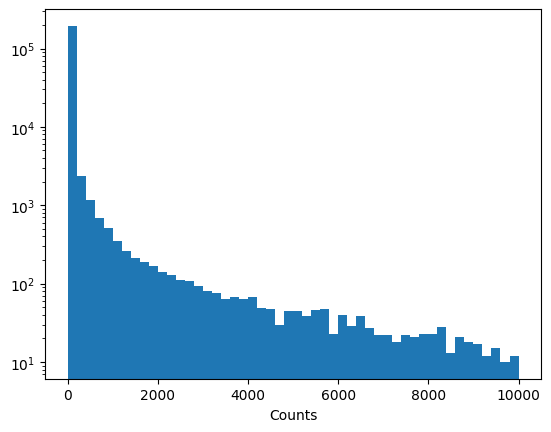

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key, value in token_counts.items() if value >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {element: idx for idx, element in enumerate(tokens)}

In [12]:
token_to_id

{'UNK': 0,
 'PAD': 1,
 'engineering': 2,
 'systems': 3,
 'analyst': 4,
 'stress': 5,
 'engineer': 6,
 'glasgow': 7,
 'modelling': 8,
 'and': 9,
 'simulation': 10,
 '/': 11,
 'mathematical': 12,
 'modeller': 13,
 'pioneer': 14,
 ',': 15,
 'water': 16,
 'industry': 17,
 'senior': 18,
 'subsea': 19,
 'pipeline': 20,
 'integrity': 21,
 'recruitment': 22,
 'consultant': 23,
 'industrial': 24,
 'commercial': 25,
 'construction': 26,
 'technical': 27,
 'trades': 28,
 'labour': 29,
 'cables': 30,
 'trainee': 31,
 'mortgage': 32,
 'advisor': 33,
 'east': 34,
 'midlands': 35,
 'project': 36,
 'pharmaceutical': 37,
 'principal': 38,
 'composite': 39,
 'fatigue': 40,
 'damage': 41,
 'tolerance': 42,
 'chef': 43,
 'de': 44,
 'partie': 45,
 'award': 46,
 'winning': 47,
 'restaurant': 48,
 'excellent': 49,
 'tips': 50,
 'quality': 51,
 'controls': 52,
 'dining': 53,
 'live': 54,
 'in': 55,
 'share': 56,
 'of': 57,
 'c': 58,
 'i': 59,
 'design': 60,
 'lead': 61,
 'engineers': 62,
 '(': 63,
 ')': 64,
 

In [13]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


In [16]:
print(data["Title"])

0                               engineering systems analyst
1                                   stress engineer glasgow
2                          modelling and simulation analyst
3         engineering systems analyst / mathematical mod...
4               pioneer , miser engineering systems analyst
                                ...                        
244763                                   teacher of science
244764                  teacher of business studies and ict
244765                                      english teacher
244766                                      supply teachers
244767                                           accountant
Name: Title, Length: 244768, dtype: object


In [17]:
print(data["Title"][::100020])

0                               engineering systems analyst
100020                             disease solicitor london
200040    global logistics & supply chain director , wes...
Name: Title, dtype: object


In [18]:
print(data['Title'][12])
print(as_matrix(data['Title'][12], max_len=4).shape)
as_matrix(data['Title'][:24:12], max_len=4)

principal composite stress engineer
(35, 1)


array([[ 2,  3,  4,  1],
       [38, 39,  5,  6]])

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [21]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [83]:
generate_batch(data_train, 3, max_len=10)['Categorical'].shape

(3, 3768)

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [22]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [23]:
len(tokens)

34158

In [25]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        print(f'text_ix -> {text_ix.shape}')
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        print(f'h -> {h.shape}')
        h = torch.transpose(h, 1, 2)
        print(f'h -> {h.shape}')
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        print(f'h -> {h.shape}')
        h = self.pool1(h)
        print(f'h -> {h.shape}')
        h =  self.relu(h)
        print(f'h -> {h.shape}')
        h = self.dense(h)
        print(f'h -> {h.shape}')
        
        return h

In [26]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

text_ix -> torch.Size([3, 6])
h -> torch.Size([3, 6, 64])
h -> torch.Size([3, 64, 6])
h -> torch.Size([3, 64, 6])
h -> torch.Size([3, 64])
h -> torch.Size([3, 64])
h -> torch.Size([3, 64])
Seems fine


__Task 2.1__ Create description encoder

In [27]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()        
        self.dense = nn.Linear(out_size, out_size)
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h
    
        

In [28]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [30]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(n_tokens=n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(in_features=n_cat_features, out_features=64)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(in_features=64, out_features=64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(in_features=3*64, out_features=1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.relu(self.dense1(cat_features)))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.output(joint_h)[:, 0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h

In [31]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)
assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

text_ix -> torch.Size([32, 11])
h -> torch.Size([32, 11, 64])
h -> torch.Size([32, 64, 11])
h -> torch.Size([32, 64, 11])
h -> torch.Size([32, 64])
h -> torch.Size([32, 64])
h -> torch.Size([32, 64])


In [33]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()


In [34]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [35]:
from tqdm.notebook import tnrange 
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=False):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [36]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [37]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
LOGS_DIR: Path = Path("runs")
LOGS_DIR.mkdir(parents=True,
               exist_ok=True) 

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [38]:
writer: SummaryWriter = create_writer(experiment_name="task",
                       model_name="FullNetwork")

for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    writer.add_scalars(main_tag="Loss",
                       tag_scalar_dict={"train_loss": train_loss / train_batches,
                                        "val_loss":val_loss / val_batches},
                       global_step=epoch_i)
    writer.add_scalars(main_tag="MAE",
                       tag_scalar_dict={"train_mae": train_mae / train_batches,
                                        "val_mae":val_mae / val_batches},
                       global_step=epoch_i)
    writer.close()
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

[INFO] Created SummaryWriter, saving to: runs\2024-02-15\task\FullNetwork...
Training:
torch.Size([32, 12])
torch.Size([32, 13])
torch.Size([32, 11])
torch.Size([32, 8])
torch.Size([32, 10])
torch.Size([32, 12])
torch.Size([32, 11])
torch.Size([32, 13])
torch.Size([32, 12])
torch.Size([32, 9])
torch.Size([32, 12])
torch.Size([32, 15])
torch.Size([32, 9])
torch.Size([32, 7])
torch.Size([32, 10])
torch.Size([32, 11])
torch.Size([32, 16])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 15])
torch.Size([32, 17])
torch.Size([32, 13])
torch.Size([32, 13])
torch.Size([32, 15])
torch.Size([32, 14])
torch.Size([32, 12])
torch.Size([32, 17])
torch.Size([32, 13])
torch.Size([32, 9])
torch.Size([32, 14])
torch.Size([32, 10])
torch.Size([32, 12])
torch.Size([32, 12])
torch.Size([32, 17])
torch.Size([32, 15])
torch.Size([32, 13])
torch.Size([32, 13])
torch.Size([32, 12])
torch.Size([32, 11])
torch.Size([32, 8])
torch.Size([32, 9])
torch.Size([32, 13])
torch.Size([32, 10])
torch.Size([32, 1

KeyboardInterrupt: 

In [101]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


KeyboardInterrupt: 

### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

Let's try to some __BatchNorm__:

In [39]:
class TitleEncoderV2(TitleEncoder):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__(n_tokens=n_tokens, out_size=out_size)
        self.batch_norm = nn.BatchNorm1d(num_features=out_size)
    
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.batch_norm(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h

In [40]:
class DescriptionEncoderV2(DescriptionEncoder):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__(n_tokens = n_tokens, out_size = out_size)
        self.batch_norm = nn.BatchNorm1d(num_features=out_size)
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.batch_norm(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h

In [41]:
class FullNetworkV2(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoderV2(n_tokens=n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoderV2(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(in_features=n_cat_features, out_features=64)
        self.batch_norm = nn.BatchNorm1d(num_features=64)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(in_features=64, out_features=64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(in_features=3*64, out_features=1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.relu(self.batch_norm(self.dense1(cat_features))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.output(joint_h)[:, 0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h

In [42]:
model = FullNetworkV2()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [40]:
writer: SummaryWriter = create_writer(experiment_name="task",
                       model_name="FullNetwork2")

for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    writer.add_scalars(main_tag="Loss",
                       tag_scalar_dict={"train_loss": train_loss / train_batches,
                                        "val_loss":val_loss / val_batches},
                       global_step=epoch_i)
    writer.add_scalars(main_tag="MAE",
                       tag_scalar_dict={"train_mae": train_mae / train_batches,
                                        "val_mae":val_mae / val_batches},
                       global_step=epoch_i)
    writer.close()
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

[INFO] Created SummaryWriter, saving to: runs\2024-02-11\task\FullNetwork2...
Training:
	Loss:	18.21118
	MAE:	104383.18209



Validation:
	Loss:	2.81658
	MAE:	52079.91822



Training:
	Loss:	2.18872
	MAE:	26315.06214



Validation:
	Loss:	1.66555
	MAE:	24347.55866



Training:
	Loss:	1.50553
	MAE:	16762.74557



Validation:
	Loss:	1.12357
	MAE:	14511.84866



Training:
	Loss:	1.09562
	MAE:	13115.50384



Validation:
	Loss:	0.85954
	MAE:	10614.14940



Training:
	Loss:	0.91329
	MAE:	11155.02147



Validation:
	Loss:	0.65987
	MAE:	9727.26598



Training:
	Loss:	0.74109
	MAE:	9655.56474



Validation:
	Loss:	0.54142
	MAE:	7374.51525



Training:
	Loss:	0.71039
	MAE:	9399.13792



Validation:
	Loss:	0.48638
	MAE:	8019.13065



Training:
	Loss:	0.53225
	MAE:	7986.18241



Validation:
	Loss:	0.39223
	MAE:	6575.07618



Training:
	Loss:	0.53825
	MAE:	7727.86745



Validation:
	Loss:	0.39428
	MAE:	7311.94519



Training:
	Loss:	0.49138
	MAE:	7404.44116



Validation:
	Loss:	0.32906
	MAE:	5812.

In [108]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


KeyboardInterrupt: 

According to graphics we didn't get any significant changes for our __loss__:




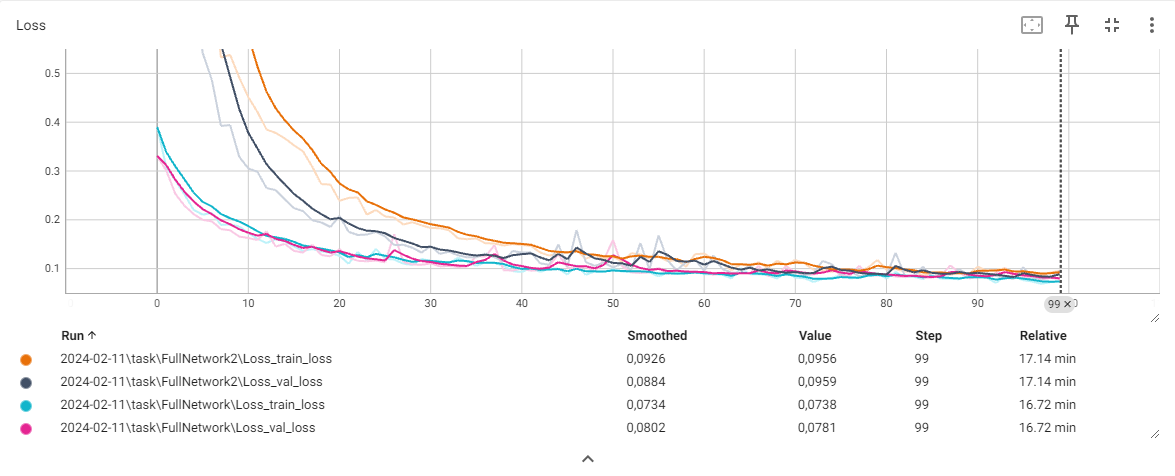



and __MAE__:




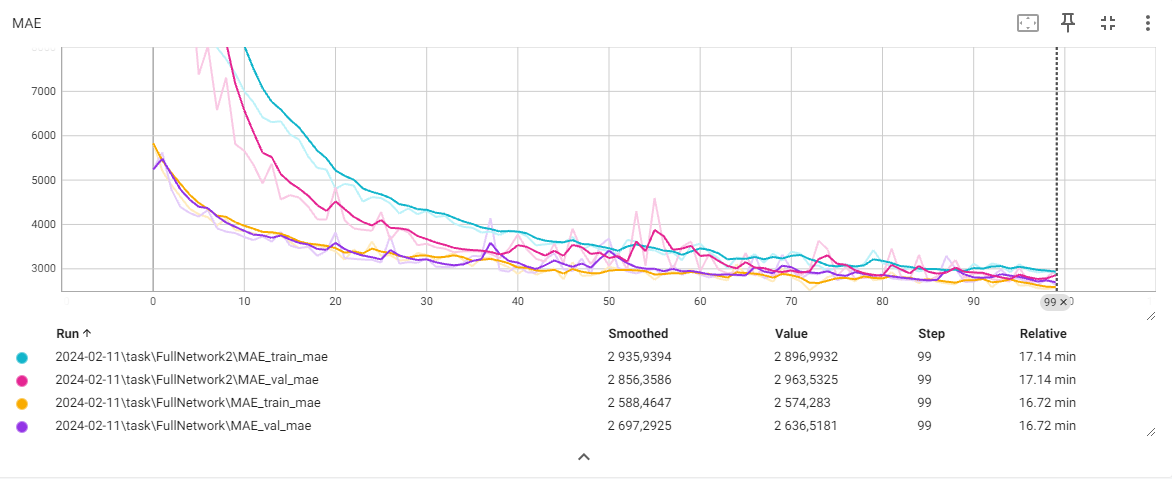

Let's try to add __parallel convolution layers__:

In [85]:
class TitleEncoderV3(TitleEncoderV2):
    def __init__(self, n_tokens=len(tokens), out_size=64, num_conv=3):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv_1 --------------> concat -> global_max -> relu -> dense
                   |            |
                    -->conv_2-->
                    -->conv_3-->
                    ............
                    -->conv_n-->
        """
        super().__init__(n_tokens=n_tokens, out_size=out_size)
        #we must redefine our dense and BatchNorm as now we will concat 2 conv outputs
        self.dense = nn.Linear(num_conv*out_size, out_size)
        self.batch_norm = nn.BatchNorm1d(num_features=64*num_conv)
        self.convs: list[nn.Conv1d] = []
        self.convs.append(self.conv1)
        for _ in range(num_conv-1):
            self.convs.append(nn.Conv1d(64, out_size, kernel_size=3, padding=1))
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        print(f'text_ix -> {text_ix.shape}')
        h = self.emb(text_ix)
        print(f'h -> {h.shape}')
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        print(f'h(transposed) -> {h.shape}')
        # Apply the layers as defined above. Add some ReLUs before dense.
        
        h_convs = []
        for i in range(len(self.convs)):
            print(self.convs[i](h).shape)
            h_convs.append(self.pool1(self.convs[i](h)))
        
        h = torch.cat(h_convs, dim=-1)
        #h = self.pool1(h)
        h = self.batch_norm(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h

In [86]:
title_encoder = TitleEncoderV3()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

text_ix -> torch.Size([3, 8])
h -> torch.Size([3, 8, 64])
h(transposed) -> torch.Size([3, 64, 8])
torch.Size([3, 64, 8])
torch.Size([3, 64, 8])
torch.Size([3, 64, 8])
Seems fine


In [52]:
class DescriptionEncoderV3(DescriptionEncoderV2):
    def __init__(self, n_tokens=len(tokens), out_size=64, num_conv=5):
        super().__init__(n_tokens = n_tokens, out_size = out_size)
        #we must redefine our dense as now we will concat 2 conv outputs
        self.dense = nn.Linear(num_conv*out_size, out_size)
        self.batch_norm = nn.BatchNorm1d(num_features=64*num_conv)
        
        self.convs: list[nn.Conv1d] = []
        self.convs.append(self.conv1)
        for _ in range(num_conv-1):
            self.convs.append(nn.Conv1d(64, out_size, kernel_size=3, padding=1))
    
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h_convs = []
        
        for i in range(len(self.convs)):
            h_convs.append(self.pool1(self.convs[i](h)))
        
        h = torch.cat(h_convs, dim=-1)
        h = self.pool1(h)
        h = self.batch_norm(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h

In [46]:
class FullNetworkV3(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoderV3(n_tokens=n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoderV3(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(in_features=n_cat_features, out_features=64)
        self.batch_norm = nn.BatchNorm1d(num_features=64)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(in_features=64, out_features=64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(in_features=3*64, out_features=1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.relu(self.batch_norm(self.dense1(cat_features))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.output(joint_h)[:, 0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h

In [47]:
model = FullNetworkV3()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [70]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)
assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [71]:
writer: SummaryWriter = create_writer(experiment_name="task",
                       model_name="FullNetwork3")

for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    writer.add_scalars(main_tag="Loss",
                       tag_scalar_dict={"train_loss": train_loss / train_batches,
                                        "val_loss":val_loss / val_batches},
                       global_step=epoch_i)
    writer.add_scalars(main_tag="MAE",
                       tag_scalar_dict={"train_mae": train_mae / train_batches,
                                        "val_mae":val_mae / val_batches},
                       global_step=epoch_i)
    writer.close()
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

[INFO] Created SummaryWriter, saving to: runs\2024-02-15\task\FullNetwork3...
Training:
	Loss:	12.39268
	MAE:	2732601.73332



Validation:
	Loss:	3.56196
	MAE:	52389.22123



Training:
	Loss:	2.27086
	MAE:	32558.62458



Validation:
	Loss:	1.43509
	MAE:	16948.59090



Training:
	Loss:	1.36738
	MAE:	16084.96756



Validation:
	Loss:	1.00808
	MAE:	11230.92595



Training:
	Loss:	0.98743
	MAE:	11872.95019



Validation:
	Loss:	0.69935
	MAE:	8713.02181



Training:
	Loss:	0.84117
	MAE:	10567.47512



Validation:
	Loss:	0.60191
	MAE:	8835.11109



Training:
	Loss:	0.75278
	MAE:	9710.36927



Validation:
	Loss:	0.55737
	MAE:	9715.29679



Training:
	Loss:	0.62710
	MAE:	8602.82855



Validation:
	Loss:	0.42513
	MAE:	6715.61868



Training:
	Loss:	0.63304
	MAE:	8563.80282



Validation:
	Loss:	0.42774
	MAE:	6966.45186



Training:
	Loss:	0.52254
	MAE:	7616.69204



Validation:
	Loss:	0.34816
	MAE:	5835.96937



Training:
	Loss:	0.46676
	MAE:	7198.99489



Validation:
	Loss:	0.36878
	MAE:	6412.

In [72]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.07384
	MAE:	2587.94041





It seems that adding parallel convs also doesn't give any signifacant changes: 

__Loss:__

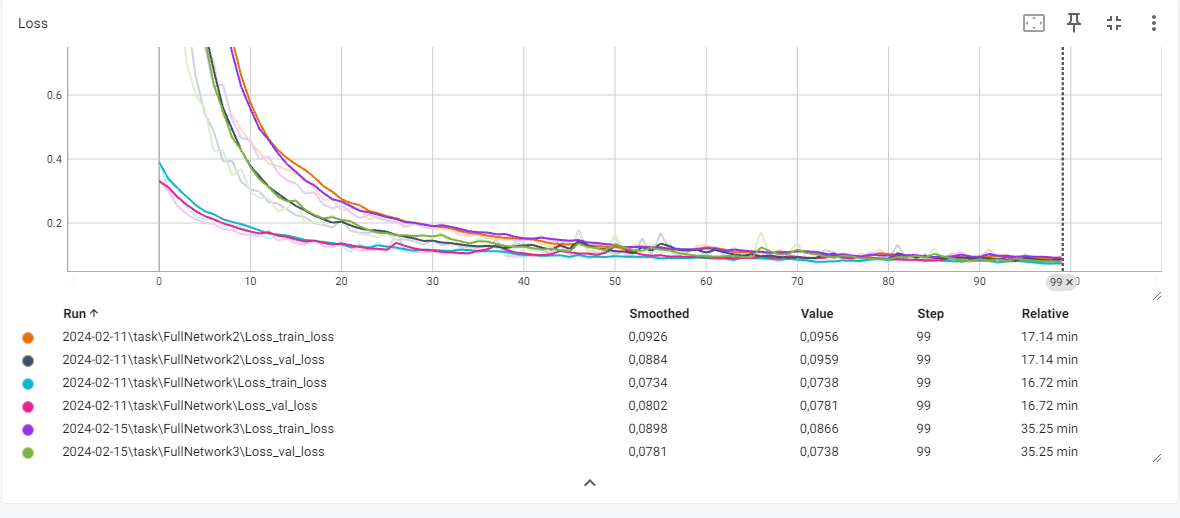

__MAE:__

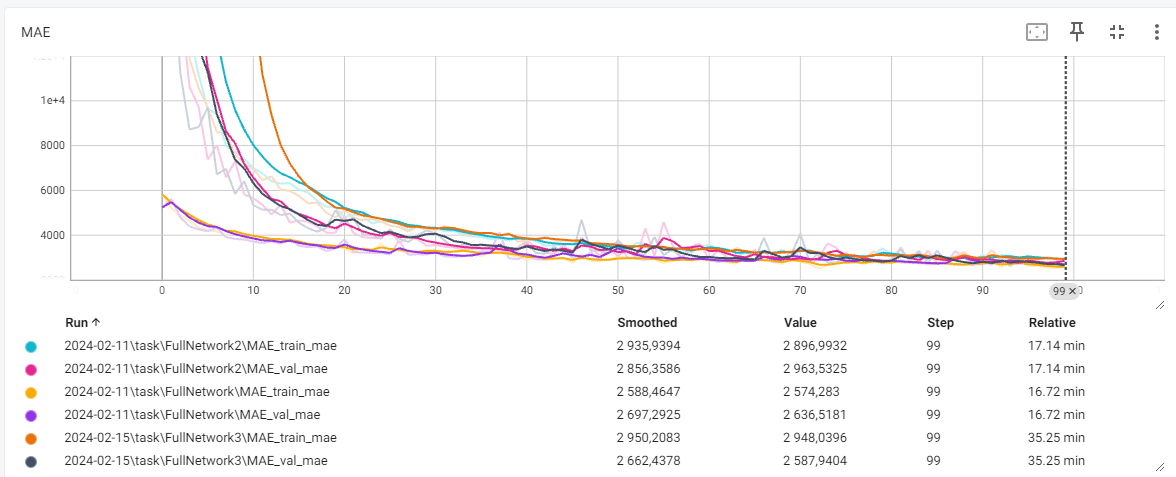

Let's try to play with __pooling:__ 

__Attention pooling:__

In [48]:
class AttentivePooling(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AttentivePooling, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(input_size, hidden_size)
        self.context_vector = nn.Parameter(torch.rand(hidden_size))

    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        print(f'inputs -> {inputs.shape}')
        attention_weights = torch.tanh(self.attention(inputs))
        print(f'attention_weights -> {attention_weights.shape}')
        # attention_weights: (batch_size, seq_len, hidden_size)
        print(f'context_vector->{self.context_vector.shape}')
        attention_scores = torch.matmul(attention_weights, self.context_vector)
        # attention_scores: (batch_size, seq_len)
        print(f'attention_scores->{attention_scores.shape}')
        attention_weights = F.softmax(attention_scores, dim=1)
        print(f'attention_weights->{attention_weights.shape}')
        # attention_weights: (batch_size, seq_len)
        print(f"attention_weights->{(attention_weights.unsqueeze(-1)).shape}")
        weighted_sum = torch.sum(inputs * attention_weights.unsqueeze(-1), dim=-1)
        print(f'inputs * attention_weights -> {(inputs * attention_weights.unsqueeze(-1)).shape}')
        # weighted_sum: (batch_size, input_size)

        return weighted_sum

In [61]:
m = AttentivePooling(input_size=12,
                     hidden_size=4)
input  = torch.randn(20, 12, 4)
print(input.shape)
input = torch.transpose(input, 1, 2)
print(input.shape)


torch.Size([20, 12, 4])
torch.Size([20, 4, 12])


In [62]:
output = m(input)
output.shape

inputs -> torch.Size([20, 4, 12])
attention_weights -> torch.Size([20, 4, 4])
context_vector->torch.Size([4])
attention_scores->torch.Size([20, 4])
attention_weights->torch.Size([20, 4])
attention_weights->torch.Size([20, 4, 1])
inputs * attention_weights -> torch.Size([20, 4, 12])


torch.Size([20, 4])

torch.Size([20, 12])


torch.Size([20])

Now let's try to add __attention pooling__ to our architecture:

In [92]:
class TitleEncoderV4(TitleEncoderV3):
    def __init__(self, n_tokens=len(tokens), out_size=64, num_conv=3):
        super().__init__(n_tokens=n_tokens, out_size=out_size, num_conv=num_conv)
        self.pool1 = AttentivePooling(input_size=out_size,
                                      hidden_size=out_size)
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        h_convs = []
        for i in range(len(self.convs)):
            print(f'After conv -> {self.convs[i](h).shape}')
            h_convs.append(self.pool1(self.convs[i](h)))
        h = torch.cat(h_convs, dim=-1)
        h = self.batch_norm(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h
    

In [93]:
title_encoder = TitleEncoderV4()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

ebat
After conv -> torch.Size([3, 64, 6])
inputs -> torch.Size([3, 64, 6])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x6 and 64x64)

In [91]:
class DescriptionEncoderV4(DescriptionEncoderV3):
    def __init__(self, n_tokens=len(tokens), out_size=64, num_conv=3):
        super().__init__(n_tokens=len(tokens), out_size=64, num_conv=3)
        self.pool1 = AttentivePooling(input_size=out_size,
                                      hidden_size=out_size)
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        h_convs = []
        for i in range(len(self.convs)):
            print(f'After conv -> {self.convs[i](h).shape}')
            h_convs.append(self.pool1(self.convs[i](h)))
        
        h = torch.cat(h_convs, dim=-1)
        h = self.batch_norm(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h

In [59]:
class FullNetworkV4(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoderV4(n_tokens=n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoderV4(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(in_features=n_cat_features, out_features=64)
        self.batch_norm = nn.BatchNorm1d(num_features=64)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(in_features=64, out_features=64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(in_features=3*64, out_features=1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.relu(self.batch_norm(self.dense1(cat_features))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.output(joint_h)[:, 0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h